In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the dataset
# Ensure the file name matches your local file
df = pd.read_csv('movie dataset.csv')

# Drop unnecessary columns immediately
if 'Wiki Page' in df.columns:
    df.drop(columns=['Wiki Page'], inplace=True)

# View raw data
print("Data Loaded.")
df.head()

Data Loaded.


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,The earliest known adaptation of the classic f...


In [4]:
# 1. Filter out 'unknown' Genres
df_clean = df[df['Genre'] != 'unknown'].copy()

# 2. Fill missing metadata with 'Unknown' to prevent errors
cols_to_fill = ['Cast', 'Director', 'Genre', 'Plot']
for col in cols_to_fill:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna('Unknown')

# 3. Print stats
print(f"Original shape: {df.shape}")
print(f"Cleaned shape:  {df_clean.shape}")
print(f"Dropped {len(df) - len(df_clean)} rows of bad data.")

Original shape: (34886, 7)
Cleaned shape:  (28803, 7)
Dropped 6083 rows of bad data.


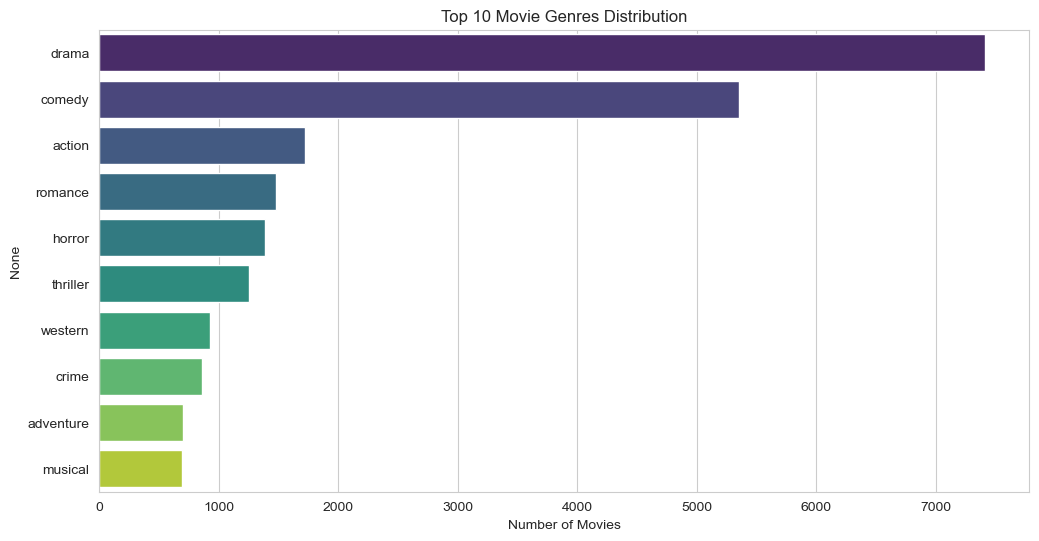

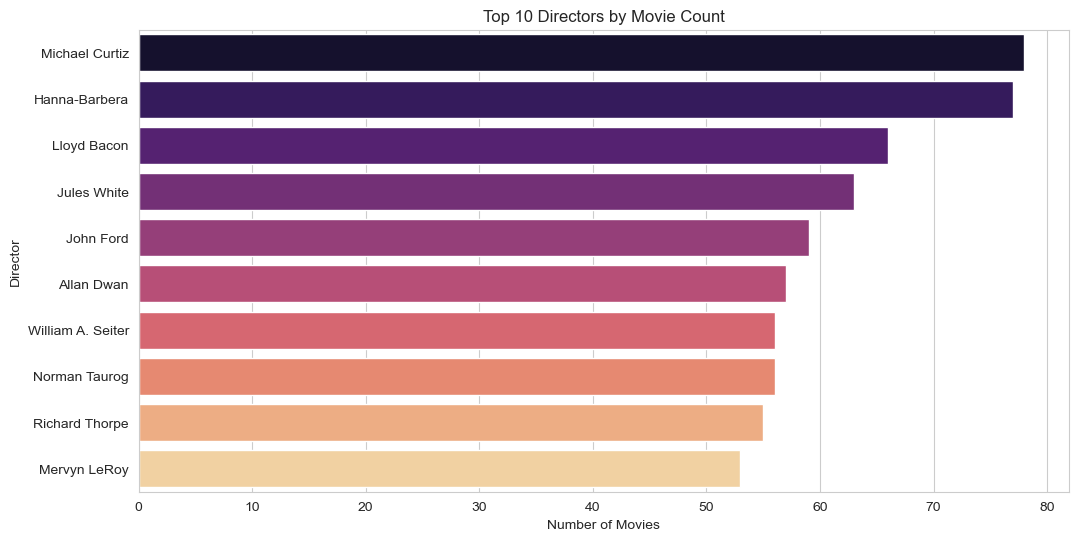

In [6]:
# Set plot style for professional look
sns.set_style("whitegrid")

# --- Chart 1: Top 10 Genres ---
plt.figure(figsize=(12, 6))
# Split genres if a movie has multiple (e.g., "Action, Crime")
all_genres = df_clean['Genre'].str.split(', ', expand=True).stack()
top_genres = all_genres.value_counts().head(10)

# FIX: Assign y to hue and set legend=False to silence the warning
sns.barplot(x=top_genres.values, y=top_genres.index, hue=top_genres.index, legend=False, palette='viridis')
plt.title('Top 10 Movie Genres Distribution')
plt.xlabel('Number of Movies')
plt.show()

# --- Chart 2: Top 10 Directors ---
plt.figure(figsize=(12, 6))
top_directors = df_clean['Director'].value_counts().head(11) 
# Filter out "Unknown" for cleaner chart
top_directors = top_directors[top_directors.index != 'Unknown']


sns.barplot(x=top_directors.values, y=top_directors.index, hue=top_directors.index, legend=False, palette='magma')
plt.title('Top 10 Directors by Movie Count')
plt.xlabel('Number of Movies')
plt.show()

In [8]:
# --- 1. Define Sanitizer (Removes spaces, lowercase) ---
def smart_sanitize(x):
    text = str(x)
    text = re.sub(r" and ", "|", text)
    text = text.replace("/", "|").replace(",", "|")
    items = text.split("|")
    clean_items = [item.strip().replace(" ", "").lower() for item in items]
    return " ".join(clean_items)

# --- 2. Apply Sanitizer to Metadata ---
features = ['Genre', 'Cast', 'Director']
for feature in features:
    df_clean[f'{feature}_feature'] = df_clean[feature].apply(smart_sanitize)

# --- 3. Clean Plot (Lowercase only) ---
if 'Plot' in df_clean.columns:
    df_clean['Plot_clean'] = df_clean['Plot'].astype(str).str.lower()

# --- 4. Create Weighted Soup ---
# Genre x4 (High Priority), Director x2 (Medium Priority)
df_clean['soup'] = (
    df_clean['Plot_clean'] + ' ' + 
    df_clean['Genre_feature'] + ' ' + df_clean['Genre_feature'] + ' ' + 
    df_clean['Genre_feature'] + ' ' + df_clean['Genre_feature'] + ' ' + 
    df_clean['Director_feature'] + ' ' + df_clean['Director_feature'] + ' ' +
    df_clean['Cast_feature']
)

print(f"Soup Example: {df_clean['soup'].iloc[0][:100]}...")

Soup Example: the film opens with two bandits breaking into a railroad telegraph office, where they force the oper...


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Drop Duplicates to ensure 1:1 mapping between ID and Title
df_final = df_clean.drop_duplicates(subset='Title', keep='first').reset_index(drop=True)
print(f"Final Unique Movies: {len(df_final)}")

# 2. Build TF-IDF Matrix (The Brain)
# min_df=5 (Ignore rare words), max_df=0.7 (Ignore common words), ngram_range=(1,2) (Phrases)
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(df_final['soup'])

# 3. Create Index Lookup
indices = pd.Series(df_final.index, index=df_final['Title'])

print("Model built and aligned successfully.")

Final Unique Movies: 27084
Model built and aligned successfully.


In [12]:
def get_recommendations(title):
    try:
        title = title.strip()
        idx = indices[title]
        
        # 1. Determine Source Genre
        source_genre = str(df_final['Genre'].iloc[idx]).lower()
        
        # 2. Define Priority Filter Tags
        priority_genres = ['action', 'comedy', 'drama', 'horror', 'romance', 
                           'superhero', 'sci-fi', 'animation', 'thriller', 'crime']
        
        required_tag = None
        for genre in priority_genres:
            if genre in source_genre:
                required_tag = genre
                break
        
        # 3. Calculate Similarity (On-Demand)
        cosine_sim_vector = linear_kernel(tfidf_matrix[idx], tfidf_matrix)
        sim_scores = list(enumerate(cosine_sim_vector[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # 4. Filter Results
        final_recommendations = []
        for item in sim_scores[1:51]: # Check top 50 matches
            movie_idx = item[0]
            target_genre = str(df_final['Genre'].iloc[movie_idx]).lower()
            
            # Enforce Genre Rule
            if required_tag and required_tag not in target_genre:
                continue
            
            final_recommendations.append(movie_idx)
            if len(final_recommendations) >= 10:
                break
        
        return df_final[['Title', 'Genre']].iloc[final_recommendations]

    except KeyError:
        return f"Movie '{title}' not found."

# Test
print(get_recommendations('The Lord of the Rings'))

                                                   Title  \
12946  The Lord of the Rings: The Fellowship of the Ring   
13332      The Lord of the Rings: The Return of the King   
13134              The Lord of the Rings: The Two Towers   
9106                              The Return of the King   
15438  Hobbit: The Desolation of Smaug, TheThe Hobbit...   
15952                                           Warcraft   
26651                      Kingsglaive: Final Fantasy XV   
21044                         Four Sisters and a Wedding   
23514                                Jab Harry Met Sejal   
23115                                              Udaan   

                                                   Genre  
12946                                            fantasy  
13332                                 adventure, fantasy  
13134                                 adventure, fantasy  
9106                                           animation  
15438                                 advent

In [14]:
import sqlite3
import pickle

# 1. Save cleaned data to SQL (for the Website UI)
conn = sqlite3.connect('movies.db')
db_columns = ['Title', 'Genre', 'Director', 'Cast', 'Plot']
# Ensure columns exist
safe_columns = [col for col in db_columns if col in df_final.columns]

# Write to SQL
df_final[safe_columns].to_sql('movies', conn, if_exists='replace', index=False)
conn.close()
print("Saved to SQL (movies.db)")

# 2. Save Model & Indices (for the Logic)
with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

with open('indices.pkl', 'wb') as f:
    pickle.dump(indices, f)

print("Saved Pickles (tfidf_matrix.pkl, indices.pkl)")

Saved to SQL (movies.db)
Saved Pickles (tfidf_matrix.pkl, indices.pkl)


In [16]:
# Test ONE MORE TIME
print(get_recommendations('Thor: Ragnarok'))

                                                   Title  \
15850                            Avengers: Age of Ultron   
13311                                               Hulk   
16151                                     Justice League   
16163                           Star Wars: The Last Jedi   
20340                                        Last Flight   
26752  Code Geass Lelouch of the Resurrection the Mov...   
16019                                 Kong: Skull Island   
26720                                  Hurricane Polymar   

                                               Genre  
15850                                         action  
13311                              superhero, action  
16151  superhero, action, adventure, fantasy, sci-fi  
16163             action, adventure, fantasy, sci-fi  
20340                                sci-fi / action  
26752   fantasy, sci-fi, action, mecha, supernatural  
16019             action, adventure, fantasy, sci-fi  
26720         actio